In [36]:
import pandas as pd
import numpy as np
import dotenv
import mlflow
import pickle
from manuscript_functions.model_utils import preprocess
from manuscript_functions.colors import default_hex, healthy_ct_cmap
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [2]:
def get_activations(clf, X):
        hidden_layer_sizes = clf.hidden_layer_sizes
        if not hasattr(hidden_layer_sizes, "__iter__"):
            hidden_layer_sizes = [hidden_layer_sizes]
        hidden_layer_sizes = list(hidden_layer_sizes)
        layer_units = [X.shape[1]] + hidden_layer_sizes + \
            [clf.n_outputs_]
        activations = [X]
        for i in range(clf.n_layers_ - 1):
            activations.append(np.empty((X.shape[0],
                                         layer_units[i + 1])))
        clf._forward_pass(activations)
        return activations

In [3]:
dotenv.load_dotenv("/Users/adr/.secrets/mlflow_server.env", override=True)
client = mlflow.tracking.MlflowClient(tracking_uri="http://mlflow.adr-services.zc2.ibm.com:5000")

In [4]:
mlp_run_id = "044b5d1659fc4d89883ec7333f0529de"
artifact_path = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Experiments/sklear_models/Expression/mlp/"

In [5]:
client.download_artifacts(run_id=mlp_run_id, path="model/model.pkl",
                          dst_path=f"{artifact_path}")
client.download_artifacts(run_id=mlp_run_id, path="scaler.pkl",
                          dst_path=f"{artifact_path}")
mlp = pickle.load(open(f"{artifact_path}model/model.pkl", 'rb'))
scaler = pickle.load(open(f"{artifact_path}scaler.pkl", 'rb'))

In [44]:
all_meta = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Model/CV_splits/Sklearn_splits/all_meta.csv",
                      index_col=0)
all_train = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Model/CV_splits/Sklearn_splits/Expression/all_expr.csv",
                       index_col=0)
y_train = all_train.pop('label')
h_b_data = preprocess(all_train, scaler, do_transform=True)


Transforming values...


In [47]:
remission_annotation = {
 0: "HSPCs",
 1: "Monocyte",
 2: "Monocyte",
 3: "Monocyte",
 4: "Monocyte",
 5: "Monocyte",
 6: "Monocyte",
 7: "Pro-Monocyte",
 8: "Pro-Monocyte",
 9: "Pro-Monocyte",
10: "HSPCs",
11: "Monoblasts/Myeloblasts",
12: "HSPCs",
13: "Monoblasts/Myeloblasts",
14: "Pro-Monocyte",
15: "HSPCs",
16: "debris",
17: "debris",
18: "debris"
}

blast_clust = [2, 3 ,4 , 5, 6 , 9, 10, 16, 18, 23, 27, 30, 7, 8, 21, 22]
monocyte_clust = [17, 26]
proMonocyte_clust = [12, 20, 14]
anno_clust = blast_clust+monocyte_clust+proMonocyte_clust

blast_dict = {clust_id: "Blast" for clust_id in all_meta["nh_cluster"].dropna().unique() if clust_id in blast_clust }
mono_dict = {clust_id: "Monocyte" for clust_id in all_meta["nh_cluster"].dropna().unique() if clust_id in monocyte_clust }
pm_dict = {clust_id: "Pro-Monocyte?" for clust_id in all_meta["nh_cluster"].dropna().unique() if clust_id in proMonocyte_clust }
remain_dict = {clust_id: "Not_defined" for clust_id in all_meta["nh_cluster"].dropna().unique() if clust_id not in anno_clust }

non_remission_anno_dict = {**blast_dict, **mono_dict, **pm_dict, **remain_dict}


all_meta.loc[~all_meta["healthy_cluster"].isna(), "cell_type"] = [remission_annotation[clust] for clust in all_meta["healthy_cluster"].dropna()]
all_meta.loc[~all_meta["nh_cluster"].isna(), "cell_type"] = [non_remission_anno_dict[clust] for clust in all_meta["nh_cluster"].dropna()]

all_meta



time_point patient_id  file_id  cluster_id  healthy_cluster  nh_cluster  \
0      Diagnosis     PAXMLI       40           5              NaN         3.0   
1      Diagnosis     PAVEDT        7           7              NaN        10.0   
2      Diagnosis     PAWHCT       21           3              NaN        22.0   
3      Diagnosis     PAXMLI       40           5              NaN         3.0   
4      Diagnosis     PAVEDT        7           7              NaN        10.0   
...          ...        ...      ...         ...              ...         ...   
12532      EOI I  TEST12378       42          30             14.0         NaN   
12533      EOI I     PAWWZL       29          12             12.0         NaN   
12534      EOI I     PAXJXC       36          18             10.0         NaN   
12535      EOI I     PAWWZL       29           3              0.0         NaN   
12536      EOI I  TEST12378       42          23              6.0         NaN   

          cell_type  
0             Blast  
1             Blast  
2             Blast  
3             Blast  
4             Blast  
...             ...  
12532  Pro-Monocyte  
12533         HSPCs  
12534         HSPCs  
12535         HSPCs  
12536      Monocyte  

[12537 rows x 7 columns]

In [7]:
act = get_activations(mlp, h_b_data)

In [8]:
for l in act:
    print(len(l[0]))

23
40
60
40
10
1


In [9]:
umapper = umap.UMAP()
Y1 = umapper.fit_transform(act[2])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

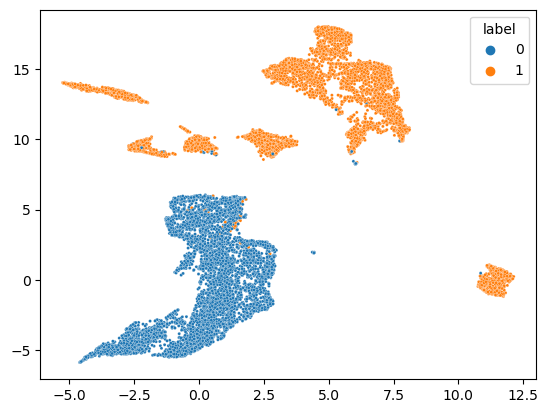

In [10]:
sns.scatterplot(Y1[:,0], Y1[:,1], hue=y_train, s=5)

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

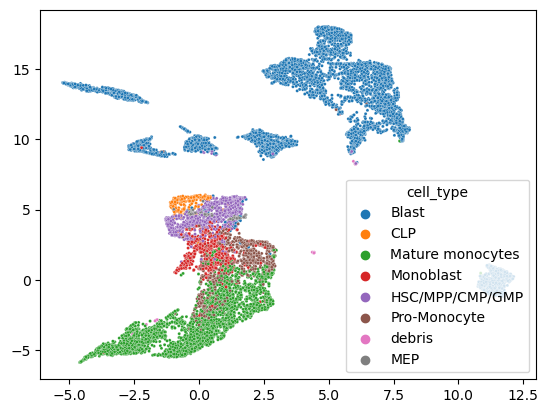

In [11]:
sns.scatterplot(Y1[:,0], Y1[:,1], hue=all_meta["cell_type"], s=5)

In [12]:
umapper2 = umap.UMAP()
Y2 = umapper.fit_transform(act[1])

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

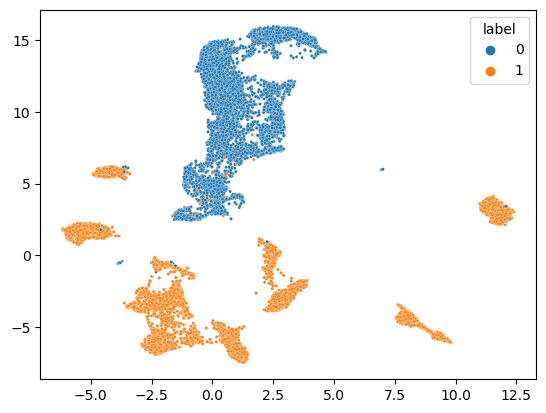

In [13]:
sns.scatterplot(Y2[:,0], Y2[:,1], hue=y_train, s=5)

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

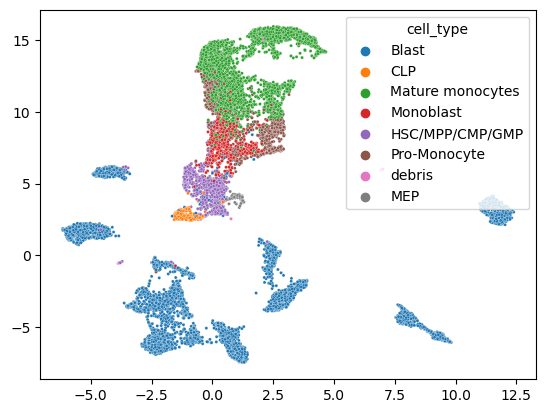

In [14]:
sns.scatterplot(Y2[:,0], Y2[:,1], hue=all_meta["cell_type"], s=5)

In [15]:
mlp_run_id = "94f56c2a4a5c42cca99b09a5d666cfe3"
artifact_path = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Experiments/sklear_models/Expression/extra_MLP/"
client.download_artifacts(run_id=mlp_run_id, path="model/model.pkl",
                          dst_path=f"{artifact_path}")
client.download_artifacts(run_id=mlp_run_id, path="scaler.pkl",
                          dst_path=f"{artifact_path}")
mlp2 = pickle.load(open(f"{artifact_path}model/model.pkl", 'rb'))
scaler2 = pickle.load(open(f"{artifact_path}scaler.pkl", 'rb'))

In [16]:
h_b_data2 = preprocess(all_train, scaler2, do_transform=True)
act2 = get_activations(mlp2, h_b_data2)

Transforming values...


In [17]:
for l in act2:
    print(len(l[0]))

23
10
4
1


/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


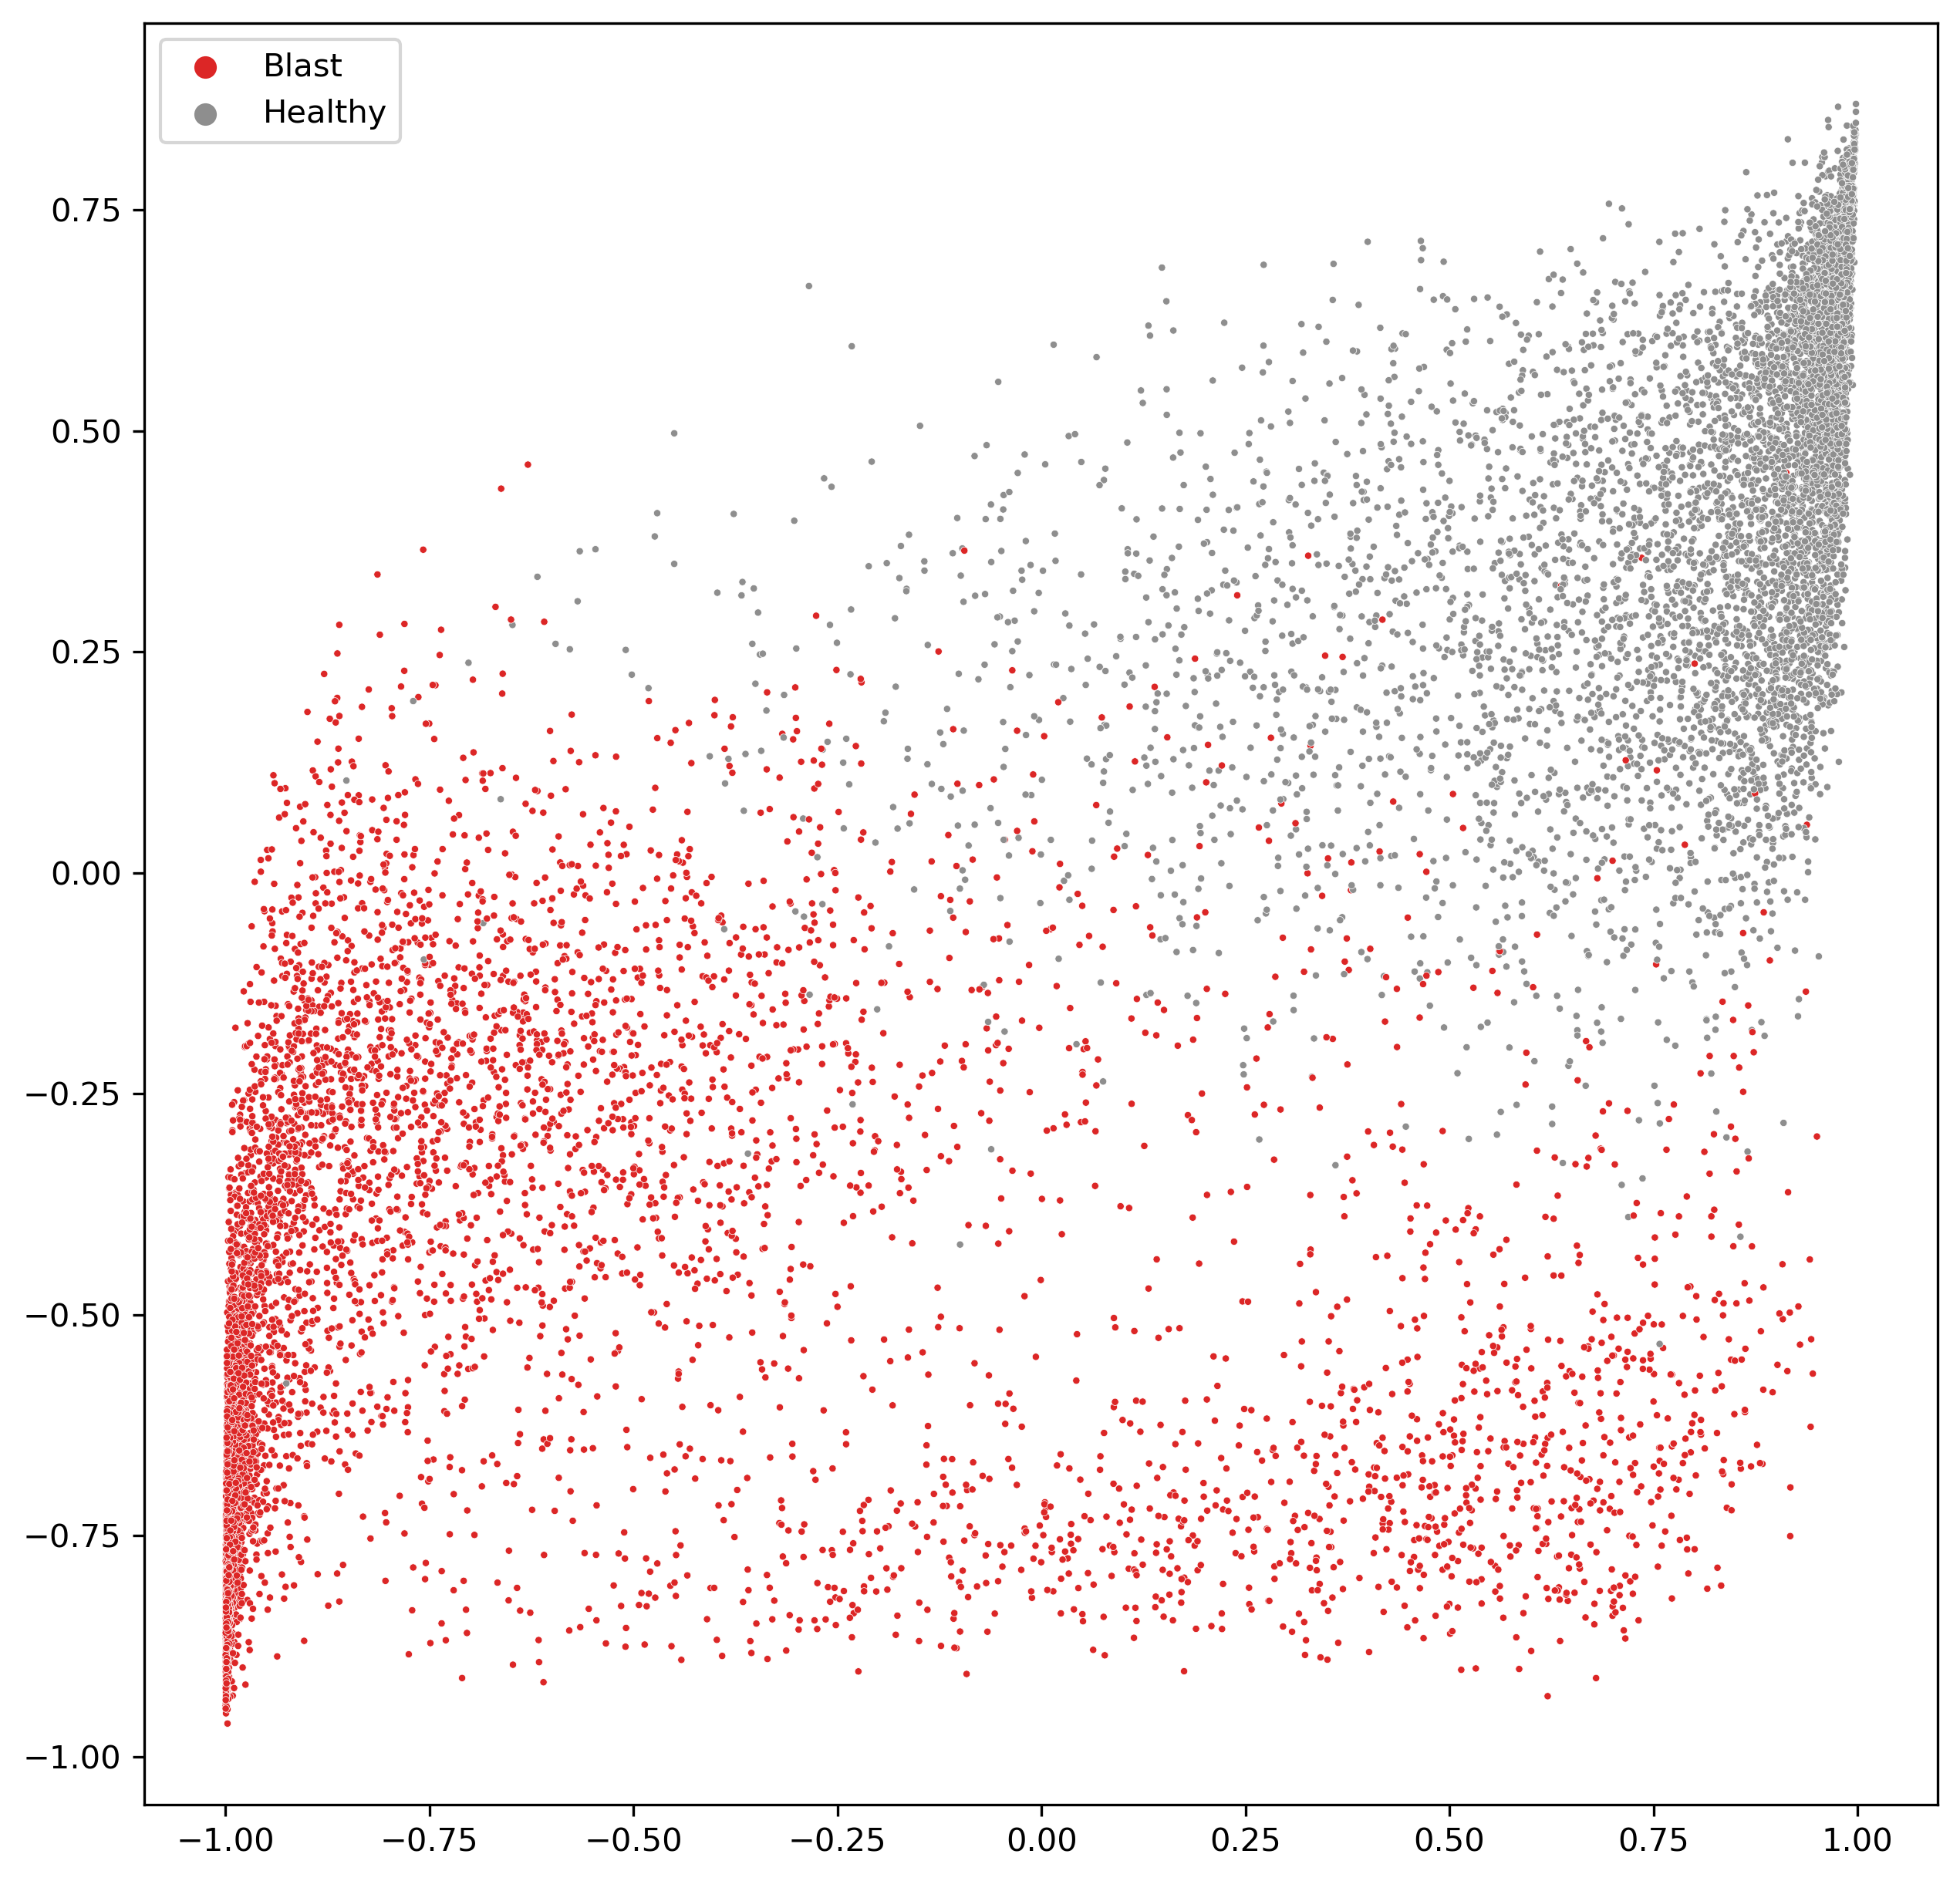

In [49]:
color = ["Blast" if label==1 else "Healthy" for label in y_train]
plt.figure(figsize=(10,10), dpi=300)
sns.scatterplot(act2[2][:,0], act2[2][:,1], hue=color, s=5, palette=[default_hex["red"], default_hex["grey"]])
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Suppl_Figure3/small_MLP_act12_healthy_blast.png")

In [38]:
healthy_ct_cmap

{'HSPCs': array([0.940015, 0.975158, 0.131326, 1.      ]),
 'Monoblasts/Myeloblasts': array([0.928329, 0.472975, 0.326067, 1.      ]),
 'Pro-Monocyte': array([0.610667, 0.090204, 0.619951, 1.      ]),
 'Monocyte': array([0.050383, 0.029803, 0.527975, 1.      ]),
 'debris': (0.5568627450980392, 0.5568627450980392, 0.5568627450980392, 1.0)}

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


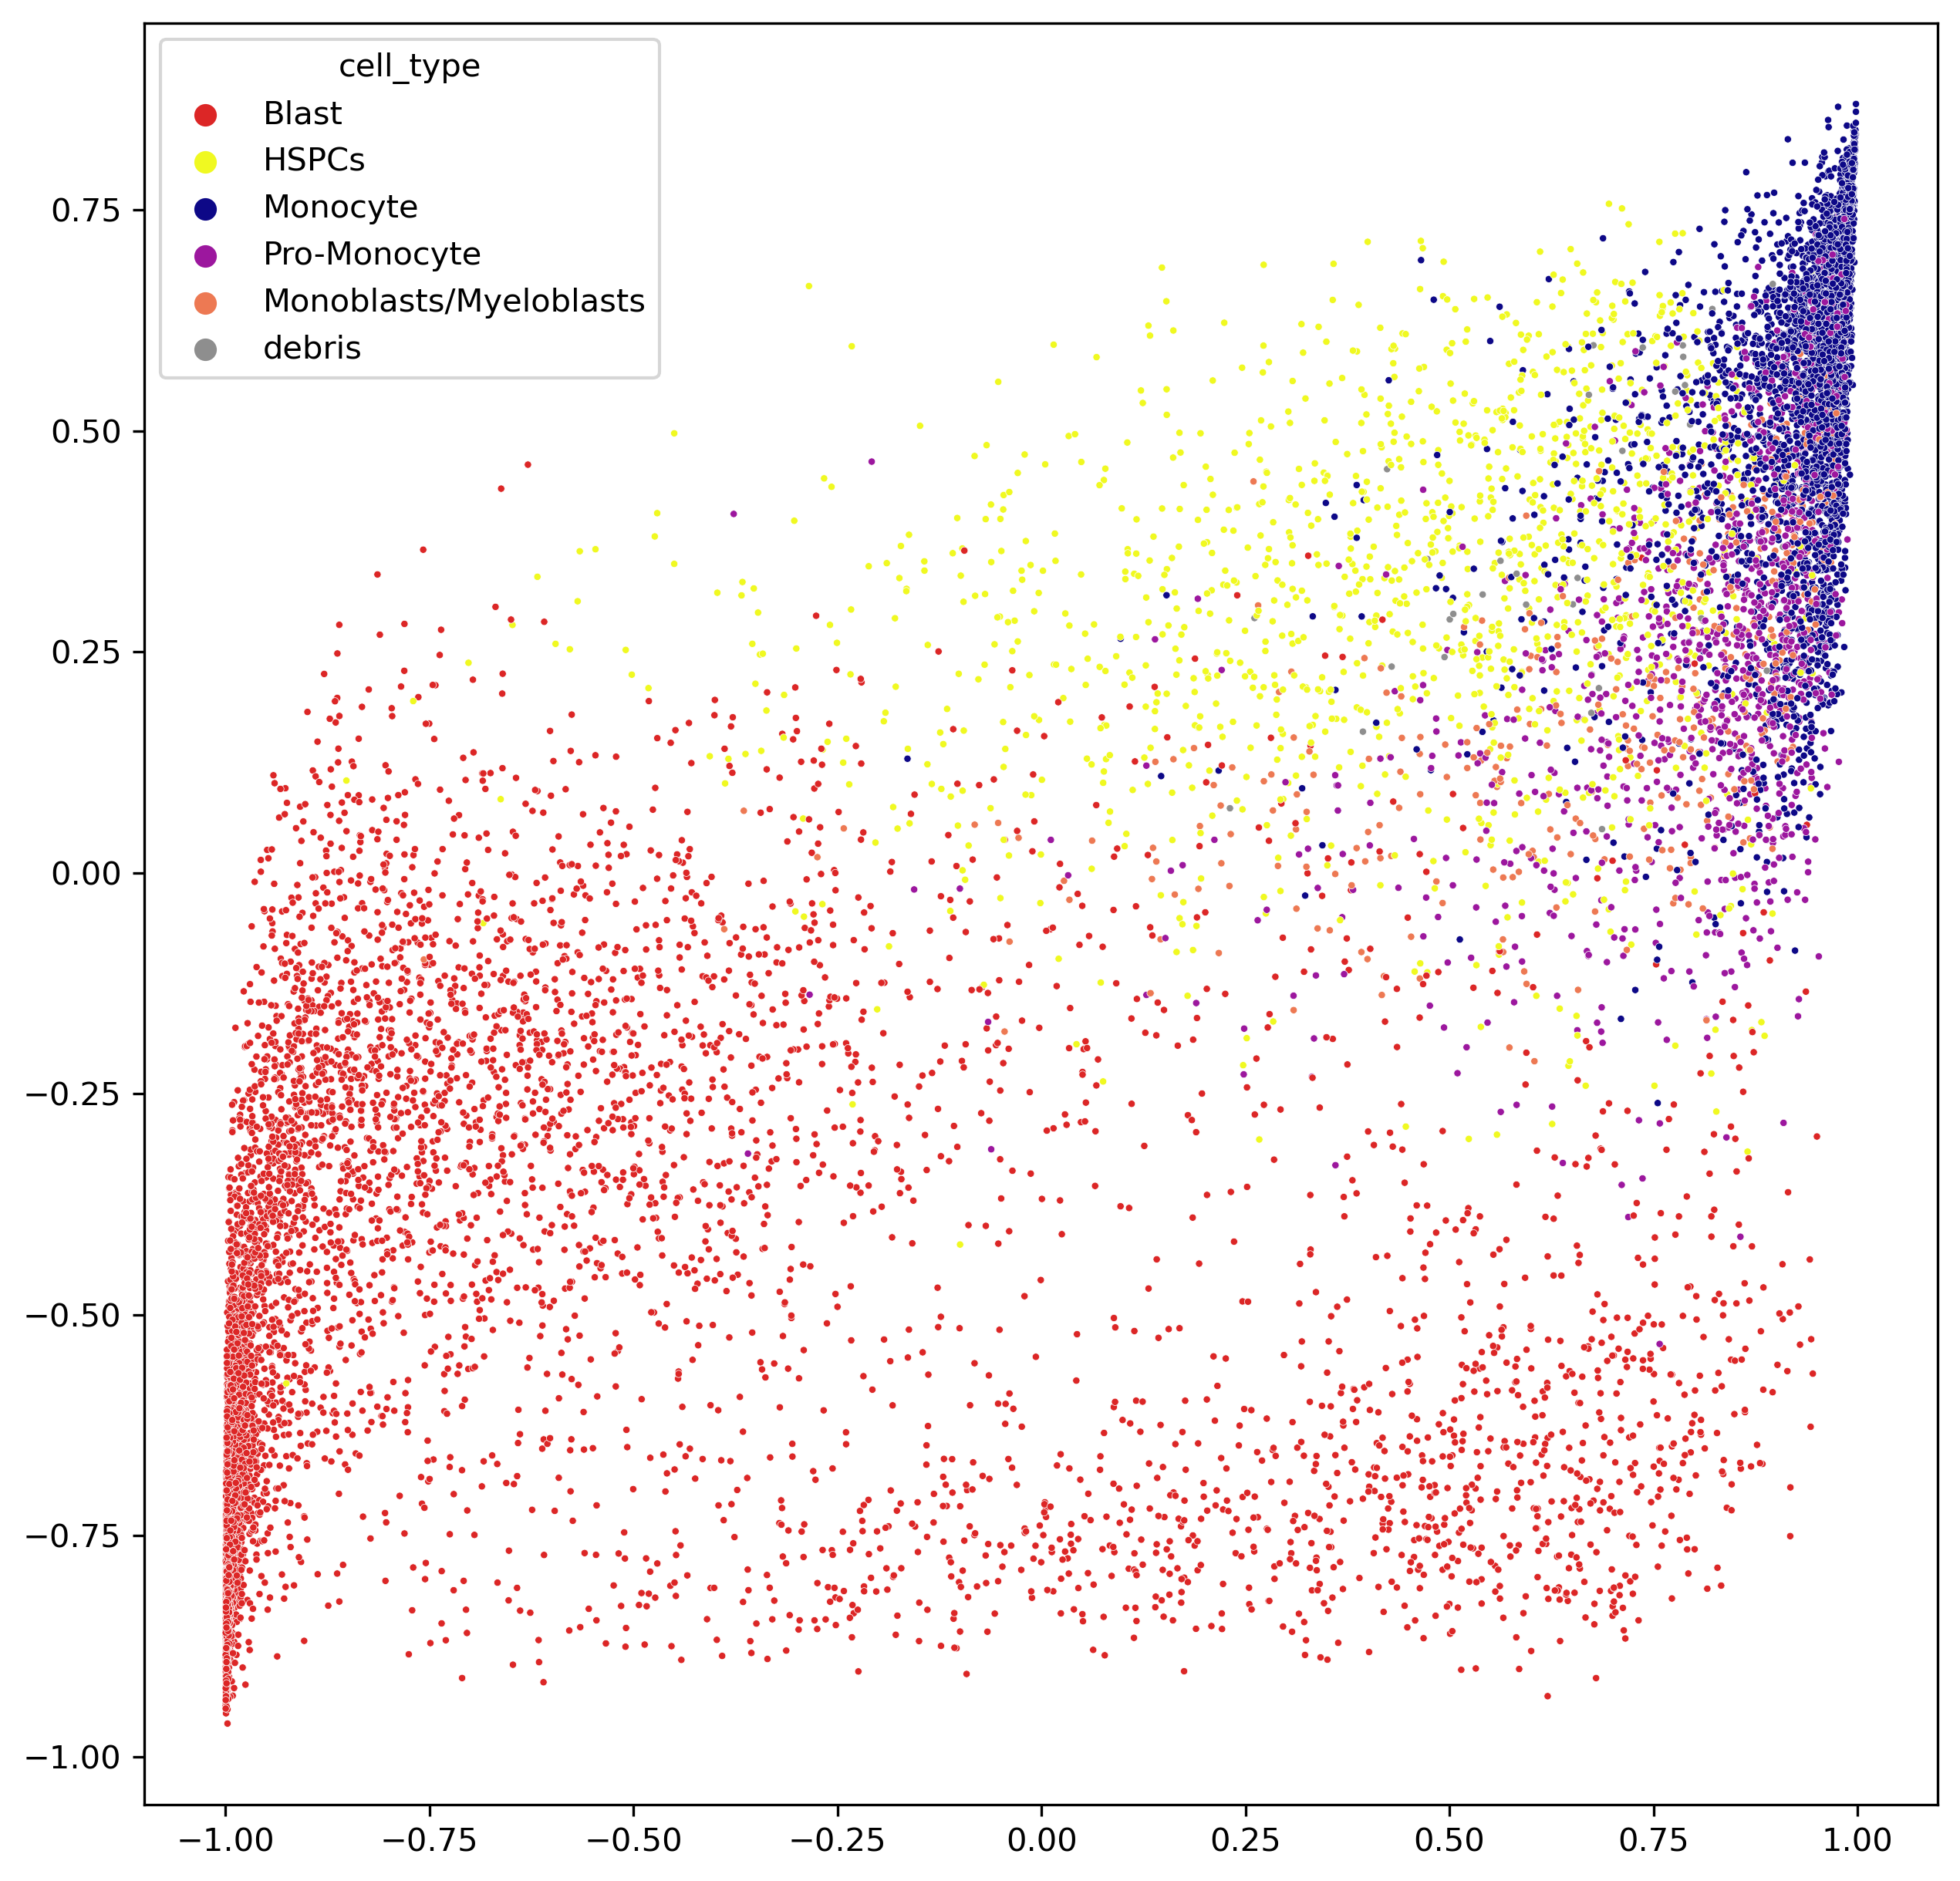

In [50]:
temp_cmap = healthy_ct_cmap.copy()
temp_cmap["Blast"] = default_hex["red"]
plt.figure(figsize=(10,10), dpi=300)
sns.scatterplot(act2[2][:,0], act2[2][:,1], hue=all_meta["cell_type"], s=5, palette=temp_cmap)
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Suppl_Figure3/small_MLP_act12_cell_type.png")

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

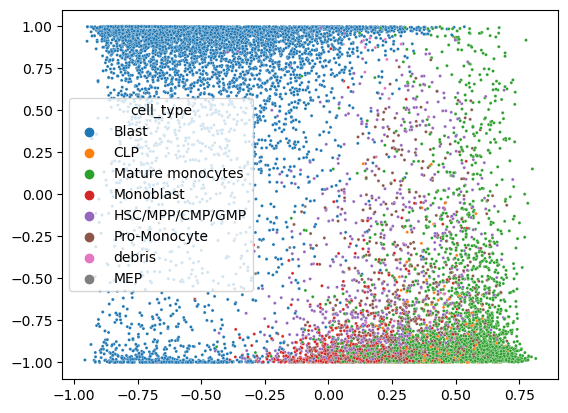

In [20]:
sns.scatterplot(act2[2][:,2], act2[2][:,3], hue=all_meta["cell_type"], s=5)

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

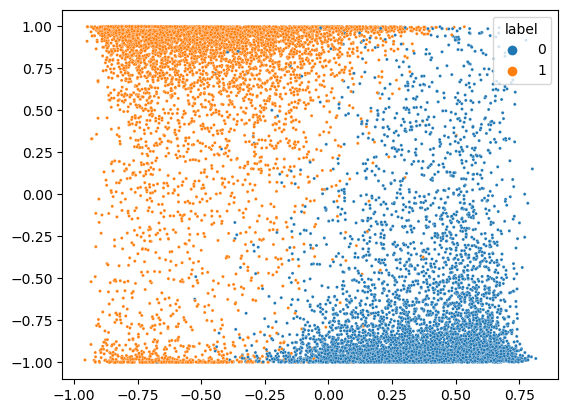

In [21]:
sns.scatterplot(act2[2][:,2], act2[2][:,3], hue=y_train, s=5)

In [22]:
umapper3 = umap.UMAP()
Y3 = umapper.fit_transform(act2[2])

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

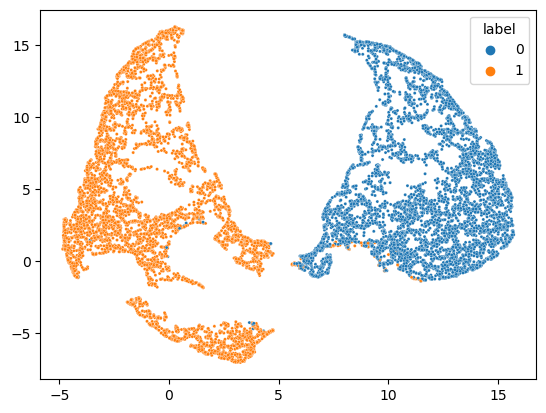

In [23]:
sns.scatterplot(Y3[:,0], Y3[:,1], hue=y_train, s=5)

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

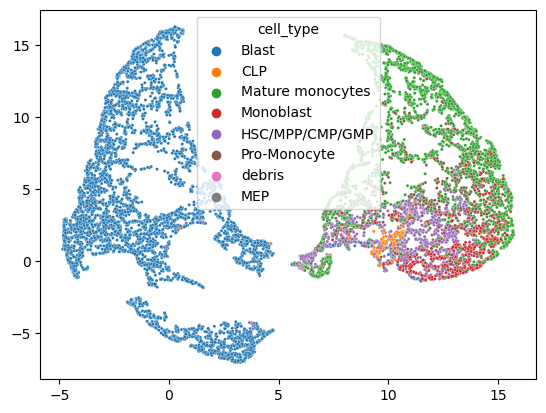

In [24]:
sns.scatterplot(Y3[:,0], Y3[:,1], hue=all_meta["cell_type"], s=5)

In [25]:
umapper4 = umap.UMAP()
Y4 = umapper.fit_transform(act2[1])

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

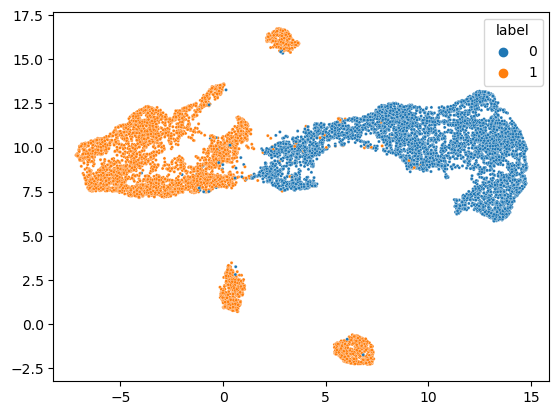

In [26]:
sns.scatterplot(Y4[:,0], Y4[:,1], hue=y_train, s=5)

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

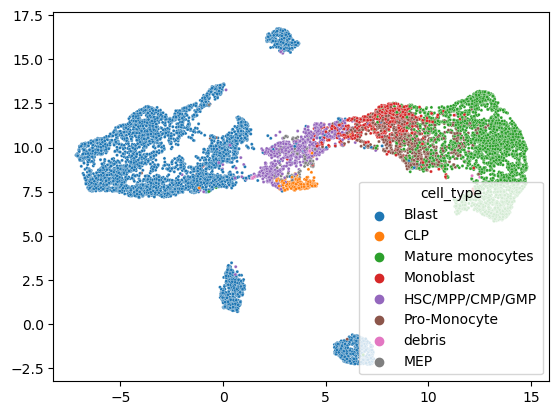

In [27]:
sns.scatterplot(Y4[:,0], Y4[:,1], hue=all_meta["cell_type"], s=5)